In [2]:
import os
import pickle
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
class CNN_TUMOR(nn.Module):
    def __init__(self, params):
        super(CNN_TUMOR, self).__init__()
        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # CNN Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(Cin, init_f, kernel_size=3, padding=1),
            nn.BatchNorm2d(init_f),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(init_f, 2 * init_f, kernel_size=3, padding=1),
            nn.BatchNorm2d(2 * init_f),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3, padding=1),
            nn.BatchNorm2d(4 * init_f),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3, padding=1),
            nn.BatchNorm2d(8 * init_f),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully Connected Layers
        self.fc1 = nn.Linear(8 * init_f * 16 * 16, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.conv4(X)
        X = X.view(X.shape[0], -1)  # Flatten
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

# ✅ Define Model Parameters
params_model = {
    "shape_in": (3, 256, 256),
    "initial_filters": 16,
    "num_fc1": 256,
    "dropout_rate": 0.2,  # Optimized Dropout
    "num_classes": 2
}

# ✅ Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN_TUMOR(params_model).to(device)

# ✅ Load Trained Model from Pickle File
model_path = "/Users/dixitrikhari/Downloads/Projects/brain-tumour-org/trained_cnn_model.pkl"
with open(model_path, "rb") as f:
    state_dict = pickle.load(f)

cnn_model.load_state_dict(state_dict)
cnn_model.eval()  # Set model to evaluation mode
print("✅ Model Loaded Successfully!")

✅ Model Loaded Successfully!


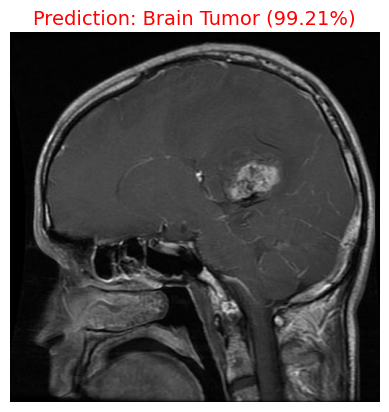

🧠 Model Prediction: Brain Tumor with 99.21% confidence.


In [6]:
# ✅ Define Image Preprocessing Function
def preprocess_new_image(image_path):
    """ Preprocess an unseen MRI image for model inference. """
    img = Image.open(image_path).convert("RGB")  # Load image in RGB mode

    # Define transformation (same as training)
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# ✅ Define Class Labels
class_labels = ["Brain Tumor", "Healthy"]

# ✅ Function to Make Predictions with Confidence Score
def predict_mri_image(image_path):
    """ Predict whether the given MRI image has a tumor or not, with confidence score. """
    img_tensor = preprocess_new_image(image_path).to(device)

    # Perform inference
    with torch.no_grad():
        output = cnn_model(img_tensor)
        probabilities = torch.softmax(output, dim=1)  # Convert log-softmax output to probabilities
        confidence, predicted_class = torch.max(probabilities, 1)  # Get highest probability and class index

    predicted_label = class_labels[predicted_class.item()]
    confidence_score = confidence.item() * 100  # Convert to percentage

    # ✅ Display the Image with Prediction and Confidence Score
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_label} ({confidence_score:.2f}%)", fontsize=14, 
              color="red" if predicted_label == "Brain Tumor" else "green")
    plt.axis("off")
    plt.show()

    return predicted_label, confidence_score

# ✅ Provide Path to Unseen MRI Scan
unseen_image_path = "/Users/dixitrikhari/Downloads/Projects/brain-tumour-org/Test_Images/t1.jpg"  # Update with actual path

# ✅ Predict & Display Result
prediction_result, confidence = predict_mri_image(unseen_image_path)
print(f"🧠 Model Prediction: {prediction_result} with {confidence:.2f}% confidence.")